In [880]:
import numpy as np
import matplotlib
from striprtf.striprtf import rtf_to_text
import pandas as pd
import re
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

def extract_numbers_from_line(line):
    # Clean the line: remove trailing backslashes and newlines
    clean_line = line.strip().rstrip('\\')
    
    # Split the cleaned line by tab characters
    values = clean_line.split('\t')
    
    # Convert the values to floats
    numeric_values = [float(value) for value in values]
    
    return numeric_values

def process_lines(lines):
    # Process each line and filter out lines that don't match the format
    processed_data = [extract_numbers_from_line(line) for line in lines if line.strip().endswith('\\')]
    return processed_data
m_p=1.672*1e-24
G=6.67*1e-8
erg=1.60218*1e-9
k=1.3807*1e16

cm=3.086*1e+21

In [881]:
with open('Surface_bright.rtf', 'r') as file:
    pattern = re.compile(r'^\d+\.\d+\t\d+\.\d+\t\d+\.\d+\\\n$')
    lines = file.readlines()
    def filter_lines(lines):
        filtered_lines = [line for line in lines if pattern.match(line)]
        return filtered_lines
    
    valid_lines = filter_lines(lines)
    numbers_lines= process_lines(valid_lines)
    

    
with open('Electron_density.rtf', 'r') as file:
    pattern = re.compile(r'^\d+\.\d+\t\d+\.\d+\t\d+\.\d+\\\n$')
    lines = file.readlines()
    def filter_lines(lines):
        filtered_lines = [line for line in lines if pattern.match(line)]
        return filtered_lines
    
    valid_lines = filter_lines(lines)
    numbers_lines_e= process_lines(valid_lines)

In [882]:
numbers=np.array(numbers_lines)
electro=np.array(numbers_lines_e)

In [883]:
SB=numbers[:, 0]
SB_error=numbers[:, 1]
r=numbers[:, 2]

SB_min=SB-SB_error
SB_max=SB+SB_error

n=electro[:, 0]
n_error=electro[:, 1]
r_el=electro[:, 2]

n_min=n-n_error
n_max=n+n_error


In [884]:

###abundance
mu=0.6

num_bins = 8

In [885]:



r_edges = np.linspace(np.min(r),np.max(r), num_bins + 1)
bin_indices = np.digitize(r, r_edges) - 1

r_means = np.array([r[bin_indices == i].mean() for i in range(num_bins)])
r_stds = np.array([r[bin_indices == i].std() for i in range(num_bins)])
r_edges = r_edges[:-1]
SB_means = [SB[bin_indices == i].mean() for i in range(num_bins)]
SB_stds = np.array([SB[bin_indices == i].std() for i in range(num_bins)])
r_edges = r_edges[:-1]



r_edges_el = np.linspace(np.min(r_el),np.max(r_el), num_bins + 1)
bin_indices = np.digitize(r_el, r_edges_el) - 1

r_means_el = np.array([r_el[bin_indices == i].mean() for i in range(num_bins)])
r_stds_el = np.array([r_el[bin_indices == i].std() for i in range(num_bins)])
r_edges_el = r_edges_el[:-1]
n_means = [n[bin_indices == i].mean() for i in range(num_bins)]
n_stds = np.array([n[bin_indices == i].std() for i in range(num_bins)])
r_edges_el = r_edges_el[:-1]




In [886]:
SB_means2 = []
SB_stds2 = []

for i in range(num_bins):
    # Select data points for the current bin
    r_bin = r[bin_indices == i]
    SB_bin = SB[bin_indices == i]
    SB_errors_bin = SB_error[bin_indices == i] 
    
    # Compute weights and weighted mean
    weights_SB = 1 / SB_errors_bin**2
    weighted_mean_SB = np.sum(weights_SB * SB_bin) / np.sum(weights_SB)
    
    # Compute weighted variance
    weighted_variance_SB = np.sum(weights_SB * (SB_bin - weighted_mean_SB)**2) / np.sum(weights_SB)
    
    # Append results to lists
    SB_means2.append(weighted_mean_SB)
    SB_stds2.append(np.sqrt(weighted_variance_SB))

# Convert lists to numpy arrays for further analysis
SB_means2 = np.array(SB_means2)
SB_stds2 = np.array(SB_stds2)

# Adjust bin edges to match the number of bins
bin_edges = bin_edges[:-1]


n_means2 = []
n_stds2 = []

for i in range(num_bins):
    # Select data points for the current bin
    r_bin = r_el[bin_indices == i]
    n_bin = n[bin_indices == i]
    n_errors_bin = n_error[bin_indices == i] 
    
    # Compute weights and weighted mean
    weights_n = 1 / n_errors_bin**2
    weighted_mean_n = np.sum(weights_n * n_bin) / np.sum(weights_n)
    
    # Compute weighted variance
    weighted_variance_n = np.sum(weights_n * (n_bin - weighted_mean_n)**2) / np.sum(weights_n)
    
    # Append results to lists
    n_means2.append(weighted_mean_n)
    n_stds2.append(np.sqrt(weighted_variance_n))

# Convert lists to numpy arrays for further analysis
n_means2 = np.array(n_means2)
n_stds2 = np.array(n_stds2)

# Adjust bin edges to match the number of bins
bin_edges = bin_edges[:-1]

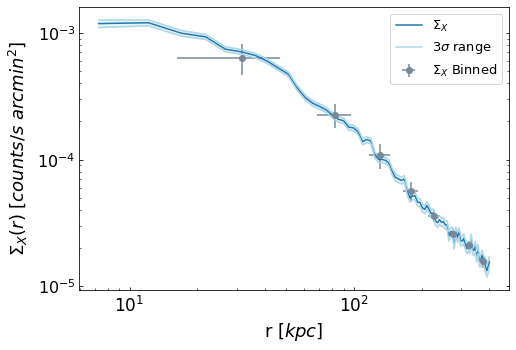

In [887]:
plt.figure(figsize=(7.7, 5.2))
plt.plot(r, SB , label='$\Sigma_X$')
plt.plot(r, SB_min, color="lightblue", label='3$\sigma$ range')
plt.plot(r, SB_max, color="lightblue")
 # Line plot with error bars
plt.errorbar(r_means, SB_means2, yerr=SB_stds2, xerr=r_stds, fmt='o', color='lightslategray', label='$\Sigma_X$ Binned')  # Scatter plot with error bars
#plt.errorbar(r_means, SB_means, yerr=SB_stds, xerr=r_stds, fmt='o', color='red', label='$\Sigma_X$ Binned') 
plt.xscale('log')
plt.yscale('log')

plt.xticks(fontsize=17)
plt.yticks(fontsize=16)
plt.tick_params(axis='x', which='both', direction='in', pad=6)  # Adjust pad to move x tick labels lower
plt.tick_params(axis='y', which='both', direction='in')
plt.fill_between(r, SB_min, SB_max, color="lightblue", alpha=0.3)

plt.xlabel('r $[kpc]$', fontsize=18, labelpad=5)
plt.ylabel(r'$\Sigma_X(r)$ [$counts/s$ $arcmin^2$]', fontsize=18,labelpad=7)
plt.tick_params(axis='both', direction='in', which='both')
ax = plt.gca()  # Get the current axes
ax.yaxis.set_ticks_position('both')  # Show ticks on both sides
ax.tick_params(axis='y', which='both', direction='in')
plt.legend(fontsize=13) 

plt.show()

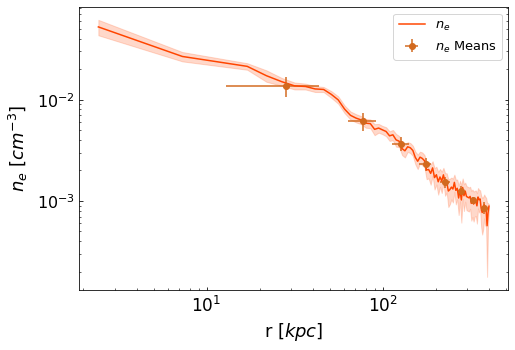

In [888]:
plt.figure(figsize=(7.7, 5.2))
plt.plot(r_el, n,  label='$n_e$', color="orangered")
#plt.errorbar(r_means_el, n_means, yerr=n_stds, xerr=r_stds_el, fmt='o', color='red', label='$\Sigma_X$ Means')  
plt.errorbar(r_means_el, n_means2, yerr=n_stds2, xerr=r_stds_el, fmt='o', color='chocolate', label='$n_e$ Means') 
plt.xscale('log')
plt.yscale('log')
plt.fill_between(r_el, n_min, n_max, color="coral", alpha=0.3)
plt.xticks(fontsize=17)
plt.yticks(fontsize=16)
plt.tick_params(axis='x', which='both', direction='in', pad=6)  # Adjust pad to move x tick labels lower
plt.tick_params(axis='y', which='both', direction='in')


plt.xlabel('r $[kpc]$', fontsize=18, labelpad=5)
plt.ylabel(r'$n_e$ [$cm^{-3}$]', fontsize=18,labelpad=7)
plt.tick_params(axis='both', direction='in', which='both')
ax = plt.gca()  # Get the current axes
ax.yaxis.set_ticks_position('both')  # Show ticks on both sides
ax.tick_params(axis='y', which='both', direction='in')
plt.legend(fontsize=13) 

plt.show()

In [889]:
def beta_bright(b, I, r, beta):
    return I*np.power((1+(b/r)**2), 1/2-3*beta)


def beta_density(b, I, r, beta):
    return I*np.power((1+(b/r)**2), -3/2*beta)


In [890]:
guess=[1e-3, 50, 3]

popt, pcov = curve_fit(beta_bright, r_means, SB_means2, p0=guess, sigma=SB_stds2)
I_f, r_f, beta_f=popt

guess=[1e-2, 50, 3]
popt, pcov = curve_fit(beta_density, r_means_el, n_means2, p0=guess, sigma=3*n_stds2)
I_n, r_n, beta_n=popt

popt, pcov = curve_fit(beta_bright, r_means, SB_means, p0=guess, sigma=SB_stds)
I_f2, r_f2, beta_f2=popt

guess=[1e-2, 50, 3]
popt, pcov = curve_fit(beta_density, r_means_el, n_means, p0=guess, sigma=3*n_stds)
I_n2, r_n2, beta_n2=popt

<ipython-input-889-d5444a5bb41a>:2: RuntimeWarning: overflow encountered in power
  return I*np.power((1+(b/r)**2), 1/2-3*beta)


In [891]:


rr=np.logspace(np.log10(np.min(r)), np.log10(np.max(r)), 1000)

0.46670699172181324


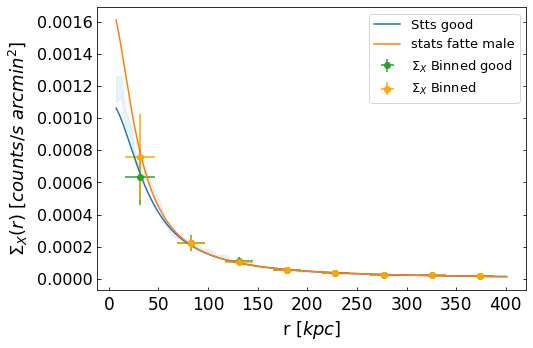

In [892]:
plt.figure(figsize=(7.7, 5.2))

 
plt.plot(rr, beta_bright(rr, I_f, r_f, beta_f), label="Stts good")
plt.plot(rr, beta_bright(rr, I_f2, r_f2, beta_f2), label="stats fatte male")
plt.errorbar(r_means, SB_means2, yerr=SB_stds2, xerr=r_stds, fmt='o', label='$\Sigma_X$ Binned good')  # Scatter plot with error bars
plt.errorbar(r_means, SB_means, yerr=SB_stds, xerr=r_stds, fmt='o', color='orange', label='$\Sigma_X$ Binned') 
#plt.xscale('log')
#plt.yscale('log')

plt.xticks(fontsize=17)
plt.yticks(fontsize=16)
plt.tick_params(axis='x', which='both', direction='in', pad=6)  # Adjust pad to move x tick labels lower
plt.tick_params(axis='y', which='both', direction='in')
plt.fill_between(r, SB_min, SB_max, color="lightblue", alpha=0.3)

plt.xlabel('r $[kpc]$', fontsize=18, labelpad=5)
plt.ylabel(r'$\Sigma_X(r)$ [$counts/s$ $arcmin^2$]', fontsize=18,labelpad=7)
plt.tick_params(axis='both', direction='in', which='both')
ax = plt.gca()  # Get the current axes
ax.yaxis.set_ticks_position('both')  # Show ticks on both sides
ax.tick_params(axis='y', which='both', direction='in')
plt.legend(fontsize=13) 
print(beta_f)
plt.show()

In [893]:
for i in range(len(rr)-1):
    M_tot[i]=(rr[i]*5*erg)/(G*0.6*m_p)*((3*0.45*rr[i]**2)/(rr[i]**2+(r_f*cm)**2))
    
M_tot[-1]=  M_tot[-2]

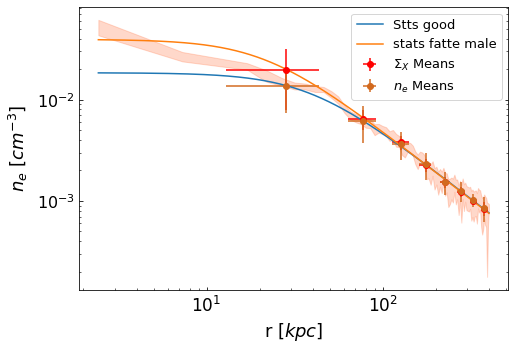

In [894]:
rr=np.logspace(np.log10(np.min(r_el)), np.log10(np.max(r_el)), 1000)

plt.figure(figsize=(7.7, 5.2))
plt.plot(rr, beta_density(rr, I_n,r_n, beta_n), label="Stts good")
plt.plot(rr, beta_density(rr, I_n2,r_n2, beta_n2), label="stats fatte male" )
plt.errorbar(r_means_el, n_means, yerr=n_stds, xerr=r_stds_el, fmt='o', color='red', label='$\Sigma_X$ Means')  
plt.errorbar(r_means_el, n_means2, yerr=2*n_stds2, xerr=r_stds_el, fmt='o', color='chocolate', label='$n_e$ Means') 
plt.xscale('log')
plt.yscale('log')
plt.fill_between(r_el, n_min, n_max, color="coral", alpha=0.3)
plt.xticks(fontsize=17)
plt.yticks(fontsize=16)
plt.tick_params(axis='x', which='both', direction='in', pad=6)  # Adjust pad to move x tick labels lower
plt.tick_params(axis='y', which='both', direction='in')


plt.xlabel('r $[kpc]$', fontsize=18, labelpad=5)
plt.ylabel(r'$n_e$ [$cm^{-3}$]', fontsize=18,labelpad=7)
plt.tick_params(axis='both', direction='in', which='both')
ax = plt.gca()  # Get the current axes
ax.yaxis.set_ticks_position('both')  # Show ticks on both sides
ax.tick_params(axis='y', which='both', direction='in')
plt.legend(fontsize=13) 

plt.show()

In [895]:
r_T=np.array([40.6, 74.1, 113.3, 170, 256.4, 377.8])
kT=np.array([3.36, 3.82, 5.61, 4.58, 5.75, 5.07])
kT_maxerror=np.array([0.3, 0.3, 0.84, 0.48, 1, 0.36])
kT_minerror=np.array([0.24, 0.33, 0.7, 0.39, 0.88, 0.35])
kT_error = [kT - kT_minerror, kT_maxerror - kT]

def T_clus(b, I, r, beta):
    return I*np.power((1+(b/r)**2), 3/2*beta)

kT_error = (kT_maxerror + kT_minerror)

ppot, covp= curve_fit(T_clus, r_T, kT , sigma=kT_error, p0=[1.23402149, 0.08747063, 0.06041828])

T_F, r_TT, alpha=ppot



In [896]:
ppot

array([1.00530657, 0.05751445, 0.06285294])

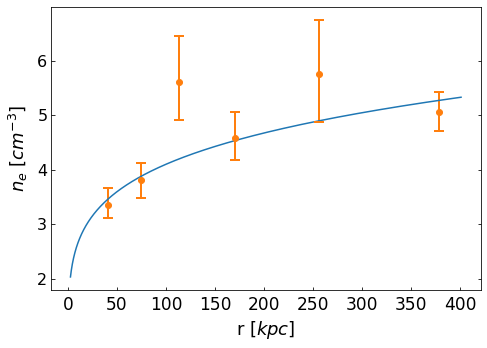

In [897]:
plt.figure(figsize=(7.7, 5.2))

plt.plot(rr, T_clus(rr, T_F, r_TT, alpha) )
plt.errorbar(r_T, kT, 
             yerr=[kT_minerror, kT_maxerror], 
             fmt='o', 
             
             capsize=5, 
             capthick=2, 
             elinewidth=2, 
             label='kT with error bars')


plt.xticks(fontsize=17)
plt.yticks(fontsize=16)
plt.tick_params(axis='x', which='both', direction='in', pad=6)  # Adjust pad to move x tick labels lower
plt.tick_params(axis='y', which='both', direction='in')


plt.xlabel('r $[kpc]$', fontsize=18, labelpad=5)
plt.ylabel(r'$n_e$ [$cm^{-3}$]', fontsize=18,labelpad=7)
plt.tick_params(axis='both', direction='in', which='both')
ax = plt.gca()  # Get the current axes
ax.yaxis.set_ticks_position('both')  # Show ticks on both sides
ax.tick_params(axis='y', which='both', direction='in')


plt.show()

In [898]:
sigma_f=(np.sqrt(beta_f*5*erg/(mu*m_p)))*1e-5
print(sigma_f)
T_F


kT=T_clus(r_means, T_F, r_TT, alpha)

610.4766354959629


In [899]:
def beta_bright_T(inputs, I, r, sigma):
    
    b, kT = inputs
    mu = 0.6
    m_p = 1.672e-24
    return I * np.power((1 + (b / r) ** 2), 1/2 - 3 * ((sigma ** 2)*(mu * m_p)/kT ))

inputs = (r_means, kT*erg)
guess=[1e-3, 50, 1e7]

popt, pcov = curve_fit(beta_bright_T, inputs, SB_means2, p0=guess, sigma=SB_stds2)
I_f, r_f, sigma_f=popt







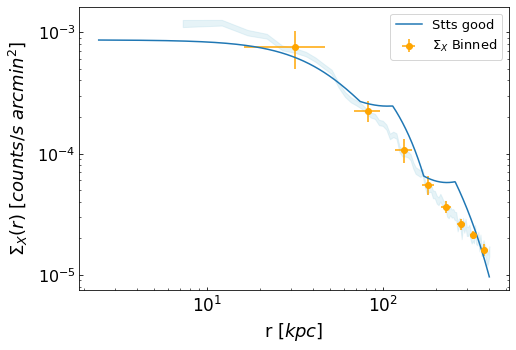

In [900]:

kT=kT_intp(rr)
inp=(rr, kT*erg)

plt.figure(figsize=(7.7, 5.2))
plt.plot(rr, beta_bright_T(inp, I_f, r_f, sigma_f), label="Stts good")


plt.errorbar(r_means, SB_means, yerr=SB_stds, xerr=r_stds, fmt='o', color='orange', label='$\Sigma_X$ Binned') 
plt.xscale('log')
plt.yscale('log')

plt.xticks(fontsize=17)
plt.yticks(fontsize=16)
plt.tick_params(axis='x', which='both', direction='in', pad=6)  # Adjust pad to move x tick labels lower
plt.tick_params(axis='y', which='both', direction='in')
plt.fill_between(r, SB_min, SB_max, color="lightblue", alpha=0.3)

plt.xlabel('r $[kpc]$', fontsize=18, labelpad=5)
plt.ylabel(r'$\Sigma_X(r)$ [$counts/s$ $arcmin^2$]', fontsize=18,labelpad=7)
plt.tick_params(axis='both', direction='in', which='both')
ax = plt.gca()  # Get the current axes
ax.yaxis.set_ticks_position('both')  # Show ticks on both sides
ax.tick_params(axis='y', which='both', direction='in')
plt.legend(fontsize=13) 


In [903]:
print(sigma_f*1e-5)

706.5659100252369


In [908]:
kT=beta_bright_T(inp, I_f, r_f, sigma_f)*erg
M_tot=np.zeros(len(rr))
beta=sigma_f**2*0.6*m_p/(kT*erg)
rr=rr*cm


for i in range(len(rr)-1):
    M_tot[i]=(rr[i]*5*erg)/(G*0.6*m_p)*((3*0.45*rr[i]**2)/(rr[i]**2+(r_f*cm)**2))
    
M_tot[-1]=  M_tot[-2]
    
    

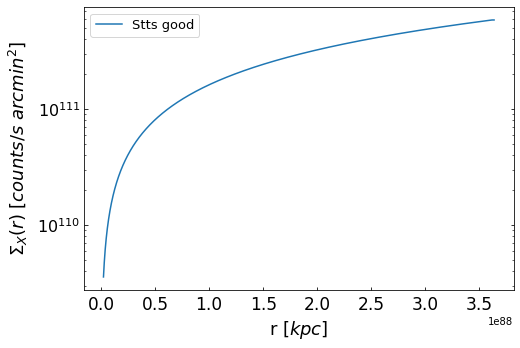

In [909]:
plt.figure(figsize=(7.7, 5.2))
plt.plot(rr, M_tot, label="Stts good")



#plt.xscale('log')
plt.yscale('log')

plt.xticks(fontsize=17)
plt.yticks(fontsize=16)
plt.tick_params(axis='x', which='both', direction='in', pad=6)  # Adjust pad to move x tick labels lower
plt.tick_params(axis='y', which='both', direction='in')


plt.xlabel('r $[kpc]$', fontsize=18, labelpad=5)
plt.ylabel(r'$\Sigma_X(r)$ [$counts/s$ $arcmin^2$]', fontsize=18,labelpad=7)
plt.tick_params(axis='both', direction='in', which='both')
ax = plt.gca()  # Get the current axes
ax.yaxis.set_ticks_position('both')  # Show ticks on both sides
ax.tick_params(axis='y', which='both', direction='in')
plt.legend(fontsize=13) 